In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

**The following poisson problem with Dirichlet boundary condition is given:**
$$-\Delta u = f \quad in \; \Omega = (0,1)^2$$
$$ u = g \quad on \quad \partial \Omega \quad$$

In [2]:
#given exact solution
def u(x,y):
    return pow(x,4)*pow(y,5)-17*np.sin(x*y)

In [3]:
#right-hand-side of the poisson equation
def fun(x,y):
    return -(17*(x**2 + y**2)*np.sin(x*y) + 4*x**2*y**3*(5*x**2 + 3*y**2))

**First, the components of the following equation will be assembled:**

$$A \underline{u} = \underline{f} + B\underline{g} \Longleftrightarrow A \underline{u} - B\underline{g} = \underline{f} = -\Delta u $$

In [4]:
# matrix A only involves inner nodes. so for m inner nodes, A is an (m x m)-matrix
def sparse_A(h):
    N = int(1/h)
    m = pow(N-1,2)
    A = np.zeros((m,m))+4*np.eye(m) - 2*np.eye(m,k=1) - 2*np.eye(m,k=-1) - 2*np.eye(m,k=N-1) - 2*np.eye(m,k=-(N-1))
    A = A + np.eye(m,k=-N) + np.eye(m,k=-(N-2)) + np.eye(m,k=N-2) + np.eye(m,k=N)
    A = pow(h,-4)*A
    # insert zeros for neighbours of inner nodes that are next to the boundary, because of lexicographical order
    for i in range(N-2):
        #right boundary, successors:
        A[(i+1)*(N-1)-1][(i+1)*(N-1)] = 0
        #left boundary, predecessors:
        A[(i+1)*(N-1)][(i+1)*(N-1)-1] = 0
        #left boundary, diagonally below:
        A[(i+1)*(N-1)][(i+1)*(N-1)-(N-2)] = 0
        
    for i in range(N-1):
        #right boundary:
        A[(i+1)*(N-1)-1][(i+1)*(N-1)-1-2] = 0
        #left boundary
        A[i*(N-1)][i*(N-1)+(2)] = 0
        #right boundary, diagonally below:
        A[i*(N-1)+N-2][i*(N-1)] = 0
        #left boundary, diagonally above:
        A[i*(N-1)][i*(N-1)+N-2] = 0
    for i in range(N-3):
        #right boundary, diagonally above:
        A[i*(N-1)+N-2][i*(N-1)+N-2+N] = 0
     
    A = sp.csr_matrix(A)
    return A

In [5]:
n = 2
N = pow(2,n)
h = 1/N

In [6]:
A = sparse_A(h).todense()
A

matrix([[1024., -512.,    0., -512.,  256.,    0.,    0.,    0.,    0.],
        [-512., 1024., -512.,  256., -512.,  256.,    0.,    0.,    0.],
        [   0., -512., 1024.,    0.,  256., -512.,    0.,    0.,    0.],
        [-512.,    0.,    0., 1024., -512.,    0., -512.,  256.,    0.],
        [ 256., -512.,  256., -512., 1024., -512.,  256., -512.,  256.],
        [   0.,  256., -512.,    0., -512., 1024.,    0.,  256., -512.],
        [   0.,    0.,  256., -512.,    0.,    0., 1024., -512.,    0.],
        [   0.,    0.,    0.,  256., -512.,  256., -512., 1024., -512.],
        [   0.,    0.,    0.,    0.,  256., -512.,    0., -512., 1024.]])

In [7]:
def vector_f(h):
    N = int(1/h)
    l = pow(N-1,2)
    f = np.zeros(l)
    for i in range(N-1):
        for k in range(N-1):
            f[k+i*(N-1)]=fun((k+1)/(N),(i+1)/(N))       
    return f

In [8]:
# for m inner nodes and l boundary nodes, B is a (m x l)-matrix
def sparse_B(h):
    N = int(1/h)
    m = pow(N-1,2)
    l = 4*N
    B = np.zeros((m,l))
    
    # since the lower and left boundary values are zero, only entries for the right
    # and upper boundary nodes are needed
    for i in range(N-1):
        #right boundary, successor:
        B[(i+1)*(N-1)-1][N + 2 * (i + 1)] = -2*pow(h,-4)
        #upper boundary:
        B[-(N-1)+i][-N+i] = -2*pow(h,-4)
        #right above
        B[-(N-1)+i][-N+i+1] = pow(h,-4)
        #left above
        B[-(N-2)+i][-N+i] = pow(h,-4)
    for i in range(N-2):
        #right boundary, diagonally above:
        B[(i+1)*(N-1)-1][N + 2 * (i + 1)+2] = pow(h,-4)
        #right boundary, diagonally below:
        B[(i+2)*(N-1)-1][N + 2 * (i + 1)] = pow(h,-4)
    
    B = sp.csr_matrix(B)
    return B

In [9]:
# example for B
n = 3
h = pow(2,-n)
B = sparse_B(h)
B.todense()[-10:-1]

matrix([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,  4096.,     0., -8192.,     0.,  4096.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,

In [10]:
# vector g of length 4*N contains the boundary values which satisfy u(x,y)
def vector_g(h):
    N = int(1/h)
    l = 4*N
    g = np.zeros(l)
    
    # upper boundary, where y=1
    for i in range(N):
        g[-N+i] = u((i+1)*h,1)
    # right boundary, where x=1    
    for i in range(N-1):    
        g[N+2+2*i] = u(1,(i+1)*h)
    return g    

In [11]:
# example for g
n = 2
h = pow(2,-n)
g = vector_g(h)
g

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -4.20489074,   0.        ,
        -8.11898416,   0.        , -11.35055423,   0.        ,
        -4.20196106,  -8.08773416, -11.27145267, -13.30500674])

In [12]:
n = 3
h = pow(2,-n)
N = pow(2,n)

In [13]:
A = sparse_A(h)
f = vector_f(h)
B = sparse_B(h)
g = vector_g(h)

**Now, the linear system Au = RHS will be solved.**

In [14]:
RHS = f+B.dot(g)
appr_u = sp.linalg.spsolve(A,RHS)

#### **Error and Consistency**

In [15]:
def exact_solution(h):
    N = int(1/h)
    l = pow(N-1,2)
    v = np.zeros(l)
    for i in range(N-1):
        for k in range(N-1):
            v[k+i*(N-1)]=u((k+1)/(N),(i+1)/(N))       
    return v

In [16]:
grid = np.zeros(7)
error_eukl = np.zeros(7)
error_inf = np.zeros(7)

for i in range(5):
    grid[i]=pow(2,-(i+2))
    h = grid[i]
    A = sparse_A(h)
    f = vector_f(h)
    B = sparse_B(h)
    g = vector_g(h)
    RHS = f+B.dot(g)
    appr_u = sp.linalg.spsolve(A,RHS)
    v = exact_solution(h)
    x = (appr_u - v)
    #print(appr_u[-1],v[-1])
    error_eukl[i] = np.linalg.norm(x)
    error_inf[i] = np.linalg.norm(x,ord = np.inf)
    

Text(0.5, 0, 'step size h')

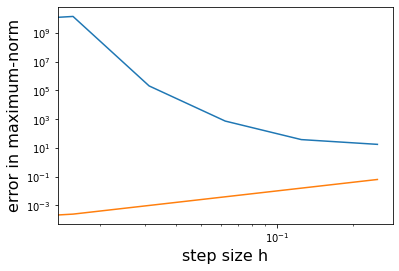

In [17]:
plt.loglog(grid,error_inf)
plt.loglog(grid, grid**2, label='2nd oder')
#plt.loglog(grid,grid, label='1st oder')
plt.ylabel('error in maximum-norm', fontsize=16)
plt.xlabel('step size h', fontsize=16)

Text(0.5, 0, 'step size h')

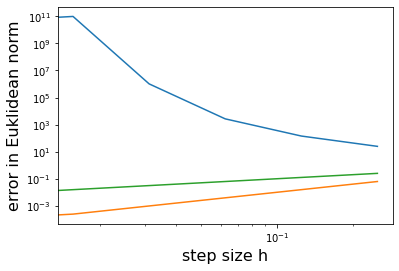

In [18]:
plt.loglog(grid,error_eukl)
plt.loglog(grid, grid**2, label='2nd oder')
plt.loglog(grid,grid, label='1st oder')
plt.ylabel('error in Euklidean norm', fontsize=16)
plt.xlabel('step size h', fontsize=16)